In [5]:
import random
import math
import time
import os
import shutil
import glob
import sys
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import bz2
from os.path import join
from collections import Counter
import matplotlib.colors as mcolors
import pickle
from tqdm.notebook import tqdm_notebook
import statsmodels.api as sm
import scipy.stats as st
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
from sklearn import linear_model
from sklearn import preprocessing
import itertools

In [6]:
directory = "../data/episodes"

In [7]:
files = glob.glob(os.path.join(directory, "*.csv"))

In [8]:
print(len(files))

139200


In [9]:
emotion_list = [
    'anger', 'disgust', 'fear', 'sadness', 'joy', 'optimism', 'love', 'caring'
]

In [13]:
positive_emotions = ['joy', 'optimism', 'love', 'caring']
negative_emotions = ['anger', 'disgust', 'fear', 'sadness']

In [14]:
# Map each emotion to a category
def get_category(emotion):
    if emotion in positive_emotions:
        return "positive"
    elif emotion in negative_emotions:
        return "negative"
    else:
        return "unknown"

In [16]:
dimensions = emotion_list
dimensions_redux = emotion_list
dimensions_names = emotion_list
dimensions_names_redux = emotion_list
dims2name = {}

for dim in emotion_list:
    if dim not in dims2name:
        dims2name[dim] = dim

def ci(x, confidence=0.95):
    avg = np.mean(x)
    low, high = st.t.interval(confidence, len(x)-1, loc=avg, scale=st.sem(x))
    return (avg, high-avg)
    
#dimension-dependent weights
def standardized_dimension_score(x,mu,std):
    zscore = (x-mu)/std
    if zscore >= 0:
        return 1/(1+zscore)
    else:
        zscore = -zscore
        return 2 - (1/(1+zscore))

In [17]:
dfs = []
for f in files: 
    try:
        temp_df = pd.read_csv(f)
        dfs.append(temp_df)
    except Exception as e:
        pass  

D = pd.concat(dfs, ignore_index=True)

In [18]:
D = D.drop(columns=[col for col in D.columns if col.endswith(".1")])
D = D.drop(columns=[col for col in D.columns if col.endswith(".2")])

In [19]:
D.columns

Index(['sentenceID', 'sentence', 'collectiveAction', 'probCollectiveAction',
       'collectiveActionLevel', 'race', 'gratitude', 'excitement', 'joy',
       'approval', 'neutral', 'admiration', 'caring', 'optimism', 'relief',
       'pride', 'realization', 'love', 'desire', 'surprise', 'annoyance',
       'curiosity', 'amusement', 'confusion', 'fear', 'anger', 'disapproval',
       'nervousness', 'sadness', 'disgust', 'disappointment', 'grief',
       'remorse', 'embarrassment'],
      dtype='object')

In [21]:
for column in emotion_list:
    D[f'{column}_weighted'] = D[column].copy()

In [22]:
D['number_of_words'] = D['sentence'].apply(lambda x: len(str(x).split()))
D['log_number_of_words'] = D['number_of_words'].apply(lambda x: np.log(x) if x > 0 else 0)

In [23]:
threshold = 0.5
for column in emotion_list:
    D[f'{column}'] = (D[column] >= threshold).astype(int)

In [24]:
mapping = {
    "Problem-Solution": "problem_solution",
    "Call-to-Action": "call_to_action",
    "Intention": "intention",
    "Execution": "execution"
}

for label, col in mapping.items():
    D[col] = (D["collectiveActionLevel"] == label).astype(int)

In [26]:
df = D[['race'] + ['collectiveAction'] + ['problem_solution'] + ['call_to_action'] + ['intention'] + ['execution'] + emotion_list + [f'{col}_weighted' for col in emotion_list] + ['log_number_of_words']]

In [ ]:
# # to find examples of problem-solution statements of different polarities
# subset = D[(D['race'] == 1) & (D['problem_solution'] == 1)]
# neg_emotions = ['anger', 'disgust', 'fear', 'sadness']
# pos_emotions = ['joy', 'optimism', 'caring', 'love']
# subset_neg = subset[subset[neg_emotions].any(axis=1)]
# subset_pos = subset[subset[pos_emotions].any(axis=1)]
# cols_to_keep = ['sentence', 'anger', 'disgust', 'fear', 'sadness', 'joy', 'optimism', 'caring', 'love']
# subset_neg = subset[subset[neg_emotions].any(axis=1)][cols_to_keep]
# subset_pos = subset[subset[pos_emotions].any(axis=1)][cols_to_keep]
# subset_neg.to_csv("../data/problem_solution_negative.csv", index=False)
# subset_pos.to_csv("../data/problem_solution_positive.csv", index=False)
# subset_neg.to_csv("../data/problem_solution_negative.csv", index=False)
# subset_pos.to_csv("../data/problem_solution_positive.csv", index=False)

++++++++++++anger
avg. delta : 0.008505788087304416 count delta: 2177576
avg. nodelta : 0.008289401985276947 count nodelta: 12460730
OR = 1.0263278854422868
#dim-delta=18522, #nodim-delta=2159054, #dim-nodelta=103292, #nodim-nodelta=12357438
++++++++++++disgust
avg. delta : 0.0006658780221677682 count delta: 2177576
avg. nodelta : 0.0015149192703798253 count nodelta: 12460730
OR = 0.439173426966582
#dim-delta=1450, #nodim-delta=2176126, #dim-nodelta=18877, #nodim-nodelta=12441853
++++++++++++fear
avg. delta : 0.0039240880685679855 count delta: 2177576
avg. nodelta : 0.004136675780632435 count nodelta: 12460730
OR = 0.9484065895642014
#dim-delta=8545, #nodim-delta=2169031, #dim-nodelta=51546, #nodim-nodelta=12409184
++++++++++++sadness
avg. delta : 0.011553672523944056 count delta: 2177576
avg. nodelta : 0.011001361878477424 count nodelta: 12460730
OR = 1.050790661758068
#dim-delta=25159, #nodim-delta=2152417, #dim-nodelta=137085, #nodim-nodelta=12323645
++++++++++++joy
avg. delta : 0.0

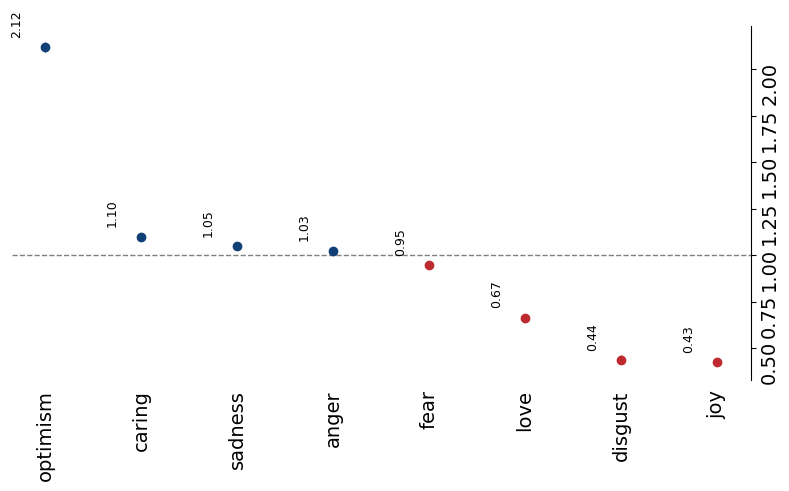

In [30]:
all_dims = dimensions_names_redux 

def ci(arr):
    arr = np.array(arr.dropna())
    n = len(arr)
    if n == 0:
        return 0, 0
    mean = np.mean(arr)
    se = np.std(arr, ddof=1) / np.sqrt(n)
    ci_val = 1.96 * se
    return mean, ci_val

df_no_delta = df[df['collectiveAction'] == 1].dropna()
df_delta = df[(df['collectiveAction'] == 0) & (df['race'] == 1)].dropna() # is collective action

# Create plot
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
y_oddsratio = []
y_ci_OR = []
y_ratio = []
y_delta = []
y_nodelta = []
y_ci_delta = []
y_ci_nodelta = []
colors = []

for dim in dimensions_names_redux:
    print(f'++++++++++++{dim}')
    
    scores_delta = df_delta[dim]
    scores_no_delta = df_no_delta[dim]

    avg_delta, ci_delta = ci(scores_delta)
    avg_no_delta, ci_no_delta = ci(scores_no_delta)

    print(f'avg. delta : {avg_delta} count delta: {len(scores_delta)}')
    print(f'avg. nodelta : {avg_no_delta} count nodelta: {len(scores_no_delta)}')

    # Avoid division by zero or log(0)
    eps = 1e-6
    avg_delta = np.clip(avg_delta, eps, 1 - eps)
    avg_no_delta = np.clip(avg_no_delta, eps, 1 - eps)

    OR = (avg_delta / (1 - avg_delta)) / (avg_no_delta / (1 - avg_no_delta))
    log_OR = np.log(OR)
    y_oddsratio.append(OR)
    y_ratio.append((avg_delta / avg_no_delta) - 1)
    y_delta.append(avg_delta / avg_no_delta)
    y_nodelta.append(avg_no_delta)
    y_ci_delta.append(ci_delta / avg_no_delta)
    y_ci_nodelta.append(ci_no_delta / avg_no_delta)

    # Get raw counts
    _dim_delta = int(avg_delta * len(scores_delta))
    _no_dim_delta = len(scores_delta) - _dim_delta
    _dim_no_delta = int(avg_no_delta * len(scores_no_delta))
    _no_dim_no_delta = len(scores_no_delta) - _dim_no_delta

    print(f'OR = {OR}')
    print(f'#dim-delta={_dim_delta}, #nodim-delta={_no_dim_delta}, #dim-nodelta={_dim_no_delta}, #nodim-nodelta={_no_dim_no_delta}')
    
    standard_error_log_OR = np.sqrt(1 / (_dim_delta + eps) + 1 / (_no_dim_delta + eps) +
                                    1 / (_dim_no_delta + eps) + 1 / (_no_dim_no_delta + eps))
    ci_log_OR = 1.96 * standard_error_log_OR
    ci_OR_upper = np.exp(log_OR + ci_log_OR)
    ci_OR_lower = np.exp(log_OR - ci_log_OR)
    ci_OR = ci_OR_upper - OR
    y_ci_OR.append(ci_OR)

    if avg_delta > avg_no_delta:
        color = '#104076'  # blue
    else:
        color = '#BD2B30'  # red
    colors.append(color)

# Prepare for plotting
L = list(zip(y_oddsratio, y_ci_OR, y_ratio, y_delta, y_ci_delta, y_nodelta, y_ci_nodelta, colors, dimensions_names_redux))
L.sort(key=lambda x: x[0], reverse=True)

labels_ordered = []
for i, (y_odds, y_odds_ci, y_rat, y_d, err_delta, y_nod, err_nodelta, color, label) in enumerate(L):
    labels_ordered.append(label)
    ax.scatter([i], [y_odds], s=10, color=color)
    ax.errorbar([i], [y_odds], yerr=[y_odds_ci], elinewidth=1, fmt='o', color=color)
    ax.text(i - 0.3, y_odds + 0.05, f'{y_odds:.2f}', ha='center', va='bottom', fontsize=9, color='black', rotation=90)

# Formatting
ax.set_xticks(range(len(labels_ordered)))
ax.set_xticklabels(labels_ordered, fontsize=14, rotation=90)
ax.yaxis.set_ticks_position('right')
ax.axhline(1, linestyle='--', linewidth=1, color='gray')

for tick in ax.get_yticklabels():
    tick.set_fontsize(14)
    tick.set_rotation(90)

ax.spines["bottom"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.xaxis.set_ticks_position("none")

plt.tight_layout()
# plt.savefig('../plots/odds_ratio.pdf')
plt.show()

In [31]:
results_data = {
    'emotion': labels_ordered,
    'odds_ratio': [l[0] for l in L],
    'lower_ci': [l[0] - l[1] for l in L],  # odds_ratio - ci
    'upper_ci': [l[0] + l[1] for l in L]   # odds_ratio + ci
}

results_df = pd.DataFrame(results_data)
results_df.to_csv('../plots/odds_ratio.csv', index=False)

### 1. Problem-solution

++++++++++++anger
avg. delta : 0.012799627993388149 count delta: 6385859
avg. nodelta : 0.01207310362178868 count nodelta: 16262879
OR = 1.0609573318034256
#dim-delta=81736, #nodim-delta=6304123, #dim-nodelta=196343, #nodim-nodelta=16066536
>>> 1.2234511108936087e-05 1.5862634659888458e-07 5.093127842601977e-06 6.224117009416342e-08
STDERR = 0.0041890937526189494
CI LOG = 0.00821062375513314
anger 0.012799627993388149 0.01207310362178868 [np.float64(0.008746981419122557)]
++++++++++++disgust
avg. delta : 0.0036098861418768762 count delta: 6385859
avg. nodelta : 0.00419146503331234 count nodelta: 16262879
OR = 0.8607441726101167
#dim-delta=23052, #nodim-delta=6362807, #dim-nodelta=68165, #nodim-nodelta=16194714
>>> 4.338018393197987e-05 1.5716334001644242e-07 1.4670285337049805e-05 6.174854338273588e-08
STDERR = 0.007633438357151308
CI LOG = 0.014961539180016564
disgust 0.0036098861418768762 0.00419146503331234 [np.float64(0.008746981419122557), np.float64(0.012974877700924092)]
+++++++

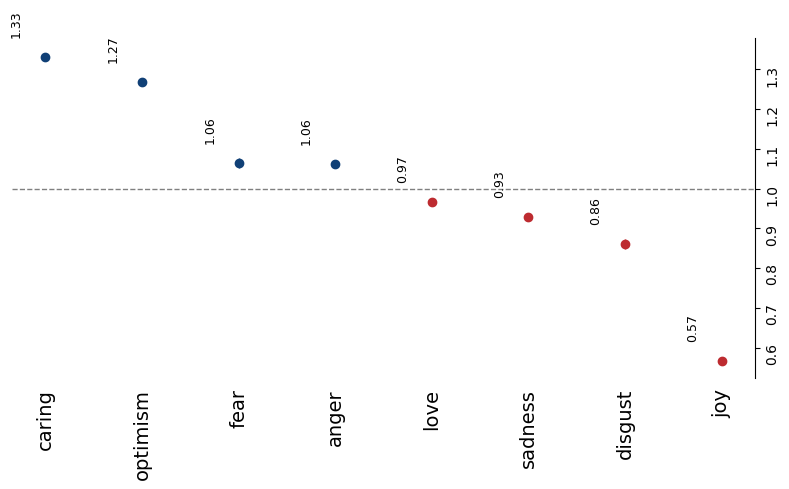

In [32]:
df_no_delta = df[df['problem_solution'] == 0].dropna()
df_delta = df[df['problem_solution'] == 1].dropna()

fig, ax = plt.subplots(1, 1, figsize=(8,5))
y_oddsratio = []
y_ci_OR = []
y_ratio = []
y_delta = []
y_nodelta = []
y_ci_delta= []
y_ci_nodelta = []
colors = []
all_dims = dimensions_names_redux 
for i, dim in enumerate(all_dims):
    
    print(f'++++++++++++{dim}')
    scores_delta = df_delta[f'{dim}_weighted'] 
    scores_no_delta = df_no_delta[f'{dim}_weighted'] 

    avg_delta, ci_delta = ci(scores_delta)
    avg_no_delta, ci_no_delta = ci(scores_no_delta)
    
    print(f'avg. delta : {avg_delta} count delta: {len(scores_delta)}')
    print(f'avg. nodelta : {avg_no_delta} count nodelta: {len(scores_no_delta)}')

    OR = (avg_delta / (1 - avg_delta)) / ( avg_no_delta / (1-avg_no_delta) )
    log_OR = np.log(OR)
    y_oddsratio.append(OR)
    y_ratio.append((avg_delta/avg_no_delta)-1)
    y_delta.append(avg_delta/avg_no_delta)
    y_nodelta.append(avg_no_delta)
    y_ci_delta.append(ci_delta/avg_no_delta)
    y_ci_nodelta.append(ci_no_delta/avg_no_delta)
    
    _dim_delta = int(avg_delta*len(scores_delta))
    _no_dim_delta = len(scores_delta) - _dim_delta
    _dim_no_delta = int(avg_no_delta*len(scores_no_delta))
    _no_dim_no_delta = len(scores_no_delta) - _dim_no_delta
    _all_cases = _dim_delta + _no_dim_delta + _dim_no_delta + _no_dim_no_delta
    
    print (f'OR = {OR}')
    print(f'#dim-delta={_dim_delta}, #nodim-delta={_no_dim_delta}, #dim-nodelta={_dim_no_delta}, #nodim-nodelta={_no_dim_no_delta}')
    
    
    print('>>>', 1/_dim_delta , 1/_no_dim_delta , 1/_dim_no_delta , 1/_no_dim_no_delta)
    standard_error_log_OR = np.sqrt(1/_dim_delta + 1/_no_dim_delta + 1/_dim_no_delta + 1/_no_dim_no_delta)
    print(f'STDERR = {standard_error_log_OR}')
    ci_log_OR = 1.96 * standard_error_log_OR
    print(f'CI LOG = {ci_log_OR}')
    ci_log_OR_upper = log_OR + ci_log_OR
    ci_log_OR_lower = log_OR - ci_log_OR
    ci_OR_upper = np.power(np.e,ci_log_OR_upper)
    ci_OR_lower = np.power(np.e,ci_log_OR_lower)
    ci_OR = ci_OR_upper - OR
    y_ci_OR.append(ci_OR)
    
    print(dim, avg_delta, avg_no_delta, y_ci_OR)
    if avg_delta > avg_no_delta:
        clr = '#104076'
    else:
        clr = '#BD2B30'  
    colors.append(clr)

L = list(zip(y_oddsratio,y_ci_OR, y_ratio, y_delta, y_ci_delta, y_nodelta, y_ci_nodelta, colors, all_dims))
L.sort(key=lambda x : x[0], reverse = True)
labels_ordered = []
y_ci_nodelta_ordered = []
for i, l in zip(range(len(L)), L):
    y_odds, y_odds_ci, y_rat, y_d, err_delta, y_nod, err_nodelta, color, label = l
    labels_ordered.append(label)
    y_ci_nodelta_ordered.append(err_nodelta)
    
    #ax.plot([i], [y_odds], 'o', markersize=1, color=color)
    ax.scatter([i], [y_odds], s=10, color=color)  
    #ax.errorbar([i], [y_odds], yerr=[y_odds_ci], elinewidth=1, fmt=f'{color}-')
    ax.errorbar([i], [y_odds], yerr=[y_odds_ci], elinewidth=1, fmt='o', color=color)
    #ax.text(i, y_odds + 0.1, f'{y_odds:.2f}', ha='center', va='bottom', fontsize=9, color='black', rotation=90)
    ax.text(i - 0.3, y_odds + 0.05, f'{y_odds:.2f}', ha='center', va='bottom', fontsize=9, color='black', rotation=90)

for tick in ax.get_xticklabels():
    tick.set_fontsize(14)  # Adjust the font size as needed
for tick in ax.get_yticklabels():
    tick.set_fontsize(14)  # Adjust the font size as needed
    
ax.set_xticks(range(len(labels_ordered)))
ax.set_xticklabels(labels_ordered)
ax.yaxis.set_ticks_position('right') 
#ax.set_ylabel(f'Odds ratio (problem-solution)', size=18)
ax.axhline(1, linestyle='--', linewidth=1, color='gray')
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
for tick in ax.get_yticklabels():
    tick.set_rotation(90)
ax.spines["bottom"].set_visible(False)
ax.spines["top"].set_visible(False)
#ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.xaxis.set_ticks_position("none")
#ax.set_xticklabels([])
plt.tight_layout()

results_data = {
    'emotion': labels_ordered,
    'odds_ratio': [l[0] for l in L],
    'lower_ci': [l[0] - l[1] for l in L],  # odds_ratio - ci
    'upper_ci': [l[0] + l[1] for l in L]   # odds_ratio + ci
}

results_df = pd.DataFrame(results_data)
results_df.to_csv('../plots/odds_ratio_problem_solution.csv', index=False)
print(f"Results saved to '../plots/odds_ratio_problem_solution.csv'")

results_df['category'] = results_df['emotion'].apply(get_category)

# Average the metrics by category
category_means = results_df.groupby('category')[['odds_ratio', 'lower_ci', 'upper_ci']].mean().reset_index()
category_means
category_means.to_csv('../plots/odds_ratio_problem_solution_simple.csv', index=False)
print(f"Results saved!")


### 2. Call-to-action

++++++++++++anger
avg. delta : 0.008099681228546417 count delta: 1295737
avg. nodelta : 0.012531493175961838 count nodelta: 21353001
OR = 0.6434581840159528
#dim-delta=10495, #nodim-delta=1285242, #dim-nodelta=267584, #nodim-nodelta=21085417
>>> 9.528346831824679e-05 7.780635864685406e-07 3.7371442238698878e-06 4.742614291194715e-08
STDERR = 0.00999230215073069
CI LOG = 0.01958491221543215
anger 0.008099681228546417 0.012531493175961838 [np.float64(0.0127262868726008)]
++++++++++++disgust
avg. delta : 0.0017406447102753509 count delta: 1295737
avg. nodelta : 0.004166257231131644 count nodelta: 21353001
OR = 0.4167806072208933
#dim-delta=2255, #nodim-delta=1293482, #dim-nodelta=88962, #nodim-nodelta=21264039
>>> 0.0004434589800443459 7.731070088335207e-07 1.124075447944066e-05 4.7027754228629846e-08
STDERR = 0.02134291145291215
CI LOG = 0.041832106447707816
disgust 0.0017406447102753509 0.004166257231131644 [np.float64(0.0127262868726008), np.float64(0.017804616717705946)]
++++++++++++f

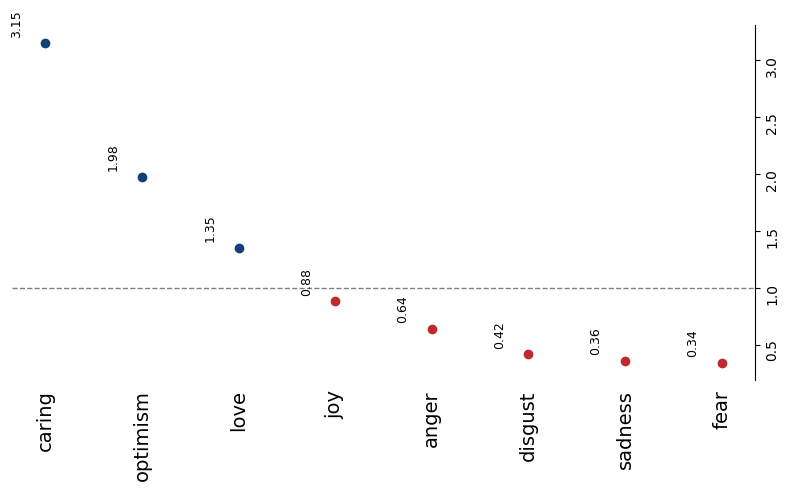

In [33]:
df_no_delta = df[df['call_to_action'] == 0].dropna()
df_delta = df[df['call_to_action'] == 1].dropna()

fig, ax = plt.subplots(1, 1, figsize=(8,5))
y_oddsratio = []
y_ci_OR = []
y_ratio = []
y_delta = []
y_nodelta = []
y_ci_delta= []
y_ci_nodelta = []
colors = []
all_dims = dimensions_names_redux 
for i, dim in enumerate(all_dims):
    
    print(f'++++++++++++{dim}')
    scores_delta = df_delta[f'{dim}_weighted'] 
    scores_no_delta = df_no_delta[f'{dim}_weighted'] 

    avg_delta, ci_delta = ci(scores_delta)
    avg_no_delta, ci_no_delta = ci(scores_no_delta)
    
    print(f'avg. delta : {avg_delta} count delta: {len(scores_delta)}')
    print(f'avg. nodelta : {avg_no_delta} count nodelta: {len(scores_no_delta)}')

    OR = (avg_delta / (1 - avg_delta)) / ( avg_no_delta / (1-avg_no_delta) )
    log_OR = np.log(OR)
    y_oddsratio.append(OR)
    y_ratio.append((avg_delta/avg_no_delta)-1)
    y_delta.append(avg_delta/avg_no_delta)
    y_nodelta.append(avg_no_delta)
    y_ci_delta.append(ci_delta/avg_no_delta)
    y_ci_nodelta.append(ci_no_delta/avg_no_delta)
    
    _dim_delta = int(avg_delta*len(scores_delta))
    _no_dim_delta = len(scores_delta) - _dim_delta
    _dim_no_delta = int(avg_no_delta*len(scores_no_delta))
    _no_dim_no_delta = len(scores_no_delta) - _dim_no_delta
    _all_cases = _dim_delta + _no_dim_delta + _dim_no_delta + _no_dim_no_delta
    
    print (f'OR = {OR}')
    print(f'#dim-delta={_dim_delta}, #nodim-delta={_no_dim_delta}, #dim-nodelta={_dim_no_delta}, #nodim-nodelta={_no_dim_no_delta}')
    
    
    print('>>>', 1/_dim_delta , 1/_no_dim_delta , 1/_dim_no_delta , 1/_no_dim_no_delta)
    standard_error_log_OR = np.sqrt(1/_dim_delta + 1/_no_dim_delta + 1/_dim_no_delta + 1/_no_dim_no_delta)
    print(f'STDERR = {standard_error_log_OR}')
    ci_log_OR = 1.96 * standard_error_log_OR
    print(f'CI LOG = {ci_log_OR}')
    ci_log_OR_upper = log_OR + ci_log_OR
    ci_log_OR_lower = log_OR - ci_log_OR
    ci_OR_upper = np.power(np.e,ci_log_OR_upper)
    ci_OR_lower = np.power(np.e,ci_log_OR_lower)
    ci_OR = ci_OR_upper - OR
    y_ci_OR.append(ci_OR)
    
    print(dim, avg_delta, avg_no_delta, y_ci_OR)
    if avg_delta > avg_no_delta:
        clr = '#104076'
    else:
        clr = '#BD2B30'  
    colors.append(clr)

L = list(zip(y_oddsratio,y_ci_OR, y_ratio, y_delta, y_ci_delta, y_nodelta, y_ci_nodelta, colors, all_dims))
L.sort(key=lambda x : x[0], reverse = True)
labels_ordered = []
y_ci_nodelta_ordered = []
for i, l in zip(range(len(L)), L):
    y_odds, y_odds_ci, y_rat, y_d, err_delta, y_nod, err_nodelta, color, label = l
    labels_ordered.append(label)
    y_ci_nodelta_ordered.append(err_nodelta)
    
    #ax.plot([i], [y_odds], 'o', markersize=1, color=color)
    ax.scatter([i], [y_odds], s=10, color=color)  
    #ax.errorbar([i], [y_odds], yerr=[y_odds_ci], elinewidth=1, fmt=f'{color}-')
    ax.errorbar([i], [y_odds], yerr=[y_odds_ci], elinewidth=1, fmt='o', color=color)
    #ax.text(i, y_odds + 0.1, f'{y_odds:.2f}', ha='center', va='bottom', fontsize=9, color='black', rotation=90)
    ax.text(i - 0.3, y_odds + 0.05, f'{y_odds:.2f}', ha='center', va='bottom', fontsize=9, color='black', rotation=90)
for tick in ax.get_xticklabels():
    tick.set_fontsize(14)  # Adjust the font size as needed
for tick in ax.get_yticklabels():
    tick.set_fontsize(14)  # Adjust the font size as needed
    
ax.set_xticks(range(len(labels_ordered)))
ax.set_xticklabels(labels_ordered)
ax.yaxis.set_ticks_position('right') 
#ax.set_ylabel(f'Odds ratio (call-to-action)', size=18)
ax.axhline(1, linestyle='--', linewidth=1, color='gray')
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
for tick in ax.get_yticklabels():
    tick.set_rotation(90)
ax.spines["bottom"].set_visible(False)
ax.spines["top"].set_visible(False)
#ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.xaxis.set_ticks_position("none")
#ax.set_xticklabels([])
plt.tight_layout()

results_data = {
    'emotion': labels_ordered,
    'odds_ratio': [l[0] for l in L],
    'lower_ci': [l[0] - l[1] for l in L],  # odds_ratio - ci
    'upper_ci': [l[0] + l[1] for l in L]   # odds_ratio + ci
}

results_df = pd.DataFrame(results_data)
results_df.to_csv('../plots/odds_ratio_call_to_action.csv', index=False)
print(f"Results saved to '../plots/odds_ratio_call_to_action.csv'")

results_df['category'] = results_df['emotion'].apply(get_category)

# Average the metrics by category
category_means = results_df.groupby('category')[['odds_ratio', 'lower_ci', 'upper_ci']].mean().reset_index()
category_means
category_means.to_csv('../plots/odds_ratio_call_to_action_simple.csv', index=False)
print(f"Results saved!")


### 3. Intention

++++++++++++anger
avg. delta : 0.004006149015387444 count delta: 1647605
avg. nodelta : 0.012926897411932078 count nodelta: 21001133
OR = 0.3071322757851568
#dim-delta=6600, #nodim-delta=1641005, #dim-nodelta=271479, #nodim-nodelta=20729654
>>> 0.00015151515151515152 6.093826648913319e-07 3.6835261659281197e-06 4.824007192787685e-08
STDERR = 0.012484242084239589
CI LOG = 0.024469114485109595
anger 0.004006149015387444 0.012926897411932078 [np.float64(0.007607955187913074)]
++++++++++++disgust
avg. delta : 0.0018924148912370666 count delta: 1647605
avg. nodelta : 0.004194990829337285 count nodelta: 21001133
OR = 0.4500723070338145
#dim-delta=3117, #nodim-delta=1644488, #dim-nodelta=88099, #nodim-nodelta=20913034
>>> 0.0003208213025344883 6.080920018875176e-07 1.1350866638667862e-05 4.7817069488817356e-08
STDERR = 0.01824357635565276
CI LOG = 0.035757409657079416
disgust 0.0018924148912370666 0.004194990829337285 [np.float64(0.007607955187913074), np.float64(0.0163846097264308)]
++++++++

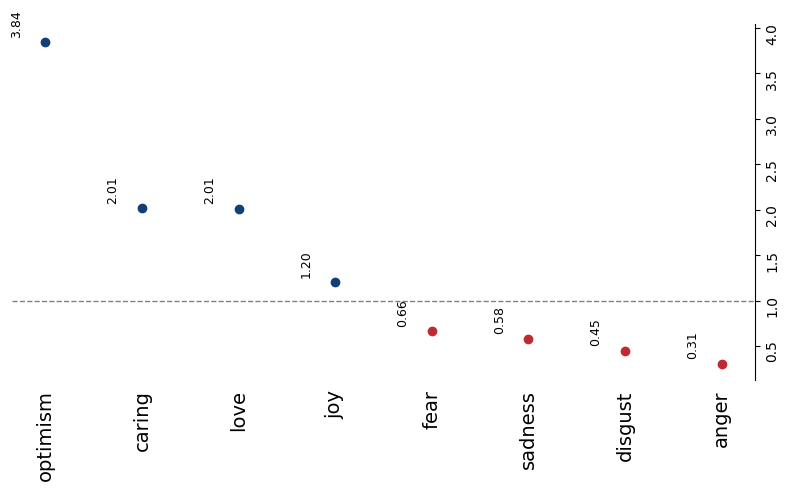

In [34]:
df_no_delta = df[df['intention'] == 0].dropna()
df_delta = df[df['intention'] == 1].dropna()

fig, ax = plt.subplots(1, 1, figsize=(8,5))
y_oddsratio = []
y_ci_OR = []
y_ratio = []
y_delta = []
y_nodelta = []
y_ci_delta= []
y_ci_nodelta = []
colors = []
all_dims = dimensions_names_redux 
for i, dim in enumerate(all_dims):
    
    print(f'++++++++++++{dim}')
    scores_delta = df_delta[f'{dim}_weighted'] 
    scores_no_delta = df_no_delta[f'{dim}_weighted'] 

    avg_delta, ci_delta = ci(scores_delta)
    avg_no_delta, ci_no_delta = ci(scores_no_delta)
    
    print(f'avg. delta : {avg_delta} count delta: {len(scores_delta)}')
    print(f'avg. nodelta : {avg_no_delta} count nodelta: {len(scores_no_delta)}')

    OR = (avg_delta / (1 - avg_delta)) / ( avg_no_delta / (1-avg_no_delta) )
    log_OR = np.log(OR)
    y_oddsratio.append(OR)
    y_ratio.append((avg_delta/avg_no_delta)-1)
    y_delta.append(avg_delta/avg_no_delta)
    y_nodelta.append(avg_no_delta)
    y_ci_delta.append(ci_delta/avg_no_delta)
    y_ci_nodelta.append(ci_no_delta/avg_no_delta)
    
    _dim_delta = int(avg_delta*len(scores_delta))
    _no_dim_delta = len(scores_delta) - _dim_delta
    _dim_no_delta = int(avg_no_delta*len(scores_no_delta))
    _no_dim_no_delta = len(scores_no_delta) - _dim_no_delta
    _all_cases = _dim_delta + _no_dim_delta + _dim_no_delta + _no_dim_no_delta
    
    print (f'OR = {OR}')
    print(f'#dim-delta={_dim_delta}, #nodim-delta={_no_dim_delta}, #dim-nodelta={_dim_no_delta}, #nodim-nodelta={_no_dim_no_delta}')
    
    
    print('>>>', 1/_dim_delta , 1/_no_dim_delta , 1/_dim_no_delta , 1/_no_dim_no_delta)
    standard_error_log_OR = np.sqrt(1/_dim_delta + 1/_no_dim_delta + 1/_dim_no_delta + 1/_no_dim_no_delta)
    print(f'STDERR = {standard_error_log_OR}')
    ci_log_OR = 1.96 * standard_error_log_OR
    print(f'CI LOG = {ci_log_OR}')
    ci_log_OR_upper = log_OR + ci_log_OR
    ci_log_OR_lower = log_OR - ci_log_OR
    ci_OR_upper = np.power(np.e,ci_log_OR_upper)
    ci_OR_lower = np.power(np.e,ci_log_OR_lower)
    ci_OR = ci_OR_upper - OR
    y_ci_OR.append(ci_OR)
    
    print(dim, avg_delta, avg_no_delta, y_ci_OR)
    if avg_delta > avg_no_delta:
        clr = '#104076'
    else:
        clr = '#BD2B30'  
    colors.append(clr)

L = list(zip(y_oddsratio,y_ci_OR, y_ratio, y_delta, y_ci_delta, y_nodelta, y_ci_nodelta, colors, all_dims))
L.sort(key=lambda x : x[0], reverse = True)
labels_ordered = []
y_ci_nodelta_ordered = []
for i, l in zip(range(len(L)), L):
    y_odds, y_odds_ci, y_rat, y_d, err_delta, y_nod, err_nodelta, color, label = l
    labels_ordered.append(label)
    y_ci_nodelta_ordered.append(err_nodelta)
    
    #ax.plot([i], [y_odds], 'o', markersize=1, color=color)
    ax.scatter([i], [y_odds], s=10, color=color)  
    #ax.errorbar([i], [y_odds], yerr=[y_odds_ci], elinewidth=1, fmt=f'{color}-')
    ax.errorbar([i], [y_odds], yerr=[y_odds_ci], elinewidth=1, fmt='o', color=color)
    #ax.text(i, y_odds + 0.1, f'{y_odds:.2f}', ha='center', va='bottom', fontsize=9, color='black', rotation=90)
    ax.text(i - 0.3, y_odds + 0.05, f'{y_odds:.2f}', ha='center', va='bottom', fontsize=9, color='black', rotation=90)

for tick in ax.get_xticklabels():
    tick.set_fontsize(14)  # Adjust the font size as needed
for tick in ax.get_yticklabels():
    tick.set_fontsize(14)  # Adjust the font size as needed
    
ax.set_xticks(range(len(labels_ordered)))
ax.set_xticklabels(labels_ordered)
ax.yaxis.set_ticks_position('right') 
#ax.set_ylabel(f'Odds ratio (intention)', size=18)
ax.axhline(1, linestyle='--', linewidth=1, color='gray')
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
for tick in ax.get_yticklabels():
    tick.set_rotation(90)
ax.spines["bottom"].set_visible(False)
ax.spines["top"].set_visible(False)
#ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.xaxis.set_ticks_position("none")
#ax.set_xticklabels([])
plt.tight_layout()

results_data = {
    'emotion': labels_ordered,
    'odds_ratio': [l[0] for l in L],
    'lower_ci': [l[0] - l[1] for l in L],  # odds_ratio - ci
    'upper_ci': [l[0] + l[1] for l in L]   # odds_ratio + ci
}

results_df = pd.DataFrame(results_data)
results_df.to_csv('../plots/odds_ratio_intention.csv', index=False)
print(f"Results saved to '../plots/odds_ratio_intention.csv'")

results_df['category'] = results_df['emotion'].apply(get_category)

# Average the metrics by category
category_means = results_df.groupby('category')[['odds_ratio', 'lower_ci', 'upper_ci']].mean().reset_index()
category_means
category_means.to_csv('../plots/odds_ratio_intention_simple.csv', index=False)
print(f"Results saved!")

### 4. Execution

++++++++++++anger
avg. delta : 0.0026335865987235168 count delta: 829880
avg. nodelta : 0.012644771881612208 count nodelta: 21818858
OR = 0.20618415903628612
#dim-delta=2185, #nodim-delta=827695, #dim-nodelta=275894, #nodim-nodelta=21542964
>>> 0.0004576659038901602 1.2081745087260404e-06 3.6245804548123554e-06 4.6418867895801155e-08
STDERR = 0.02150686117781008
CI LOG = 0.04215344790850776
anger 0.0026335865987235168 0.012644771881612208 [np.float64(0.008877160206349266)]
++++++++++++disgust
avg. delta : 0.0014600765745065459 count delta: 829880
avg. nodelta : 0.004125139098935325 count nodelta: 21818858
OR = 0.35300135449255465
#dim-delta=1211, #nodim-delta=828669, #dim-nodelta=90005, #nodim-nodelta=21728853
>>> 0.0008257638315441783 1.2067544459850676e-06 1.1110493861452142e-05 4.602175733804265e-08
STDERR = 0.02895042489513675
CI LOG = 0.056742832794468026
disgust 0.0014600765745065459 0.004125139098935325 [np.float64(0.008877160206349266), np.float64(0.020609487706794827)]
+++++++

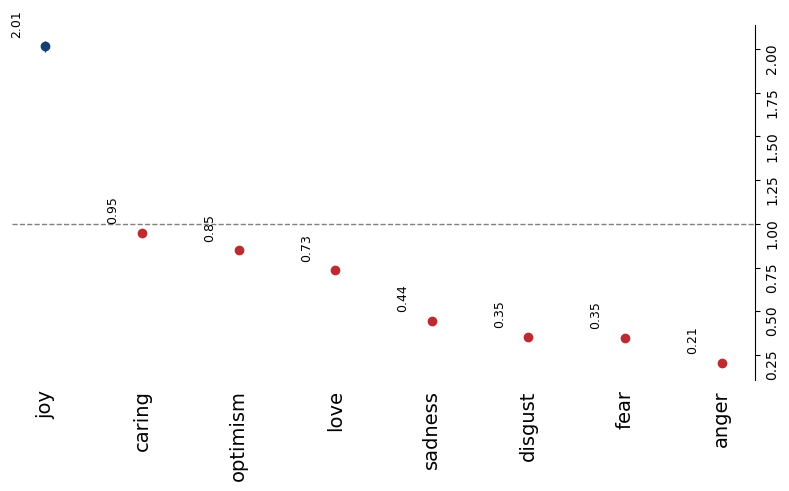

In [35]:
df_no_delta = df[df['execution'] == 0].dropna()
df_delta = df[df['execution'] == 1].dropna()

fig, ax = plt.subplots(1, 1, figsize=(8,5))
y_oddsratio = []
y_ci_OR = []
y_ratio = []
y_delta = []
y_nodelta = []
y_ci_delta= []
y_ci_nodelta = []
colors = []
all_dims = dimensions_names_redux 
for i, dim in enumerate(all_dims):
    
    print(f'++++++++++++{dim}')
    scores_delta = df_delta[f'{dim}_weighted'] 
    scores_no_delta = df_no_delta[f'{dim}_weighted'] 

    avg_delta, ci_delta = ci(scores_delta)
    avg_no_delta, ci_no_delta = ci(scores_no_delta)
    
    print(f'avg. delta : {avg_delta} count delta: {len(scores_delta)}')
    print(f'avg. nodelta : {avg_no_delta} count nodelta: {len(scores_no_delta)}')

    OR = (avg_delta / (1 - avg_delta)) / ( avg_no_delta / (1-avg_no_delta) )
    log_OR = np.log(OR)
    y_oddsratio.append(OR)
    y_ratio.append((avg_delta/avg_no_delta)-1)
    y_delta.append(avg_delta/avg_no_delta)
    y_nodelta.append(avg_no_delta)
    y_ci_delta.append(ci_delta/avg_no_delta)
    y_ci_nodelta.append(ci_no_delta/avg_no_delta)
    
    _dim_delta = int(avg_delta*len(scores_delta))
    _no_dim_delta = len(scores_delta) - _dim_delta
    _dim_no_delta = int(avg_no_delta*len(scores_no_delta))
    _no_dim_no_delta = len(scores_no_delta) - _dim_no_delta
    _all_cases = _dim_delta + _no_dim_delta + _dim_no_delta + _no_dim_no_delta
    
    print (f'OR = {OR}')
    print(f'#dim-delta={_dim_delta}, #nodim-delta={_no_dim_delta}, #dim-nodelta={_dim_no_delta}, #nodim-nodelta={_no_dim_no_delta}')
    
    
    print('>>>', 1/_dim_delta , 1/_no_dim_delta , 1/_dim_no_delta , 1/_no_dim_no_delta)
    standard_error_log_OR = np.sqrt(1/_dim_delta + 1/_no_dim_delta + 1/_dim_no_delta + 1/_no_dim_no_delta)
    print(f'STDERR = {standard_error_log_OR}')
    ci_log_OR = 1.96 * standard_error_log_OR
    print(f'CI LOG = {ci_log_OR}')
    ci_log_OR_upper = log_OR + ci_log_OR
    ci_log_OR_lower = log_OR - ci_log_OR
    ci_OR_upper = np.power(np.e,ci_log_OR_upper)
    ci_OR_lower = np.power(np.e,ci_log_OR_lower)
    ci_OR = ci_OR_upper - OR
    y_ci_OR.append(ci_OR)
    
    print(dim, avg_delta, avg_no_delta, y_ci_OR)
    if avg_delta > avg_no_delta:
        clr = '#104076'
    else:
        clr = '#BD2B30'  
    colors.append(clr)

L = list(zip(y_oddsratio,y_ci_OR, y_ratio, y_delta, y_ci_delta, y_nodelta, y_ci_nodelta, colors, all_dims))
L.sort(key=lambda x : x[0], reverse = True)
labels_ordered = []
y_ci_nodelta_ordered = []
for i, l in zip(range(len(L)), L):
    y_odds, y_odds_ci, y_rat, y_d, err_delta, y_nod, err_nodelta, color, label = l
    labels_ordered.append(label)
    y_ci_nodelta_ordered.append(err_nodelta)
    
    #ax.plot([i], [y_odds], 'o', markersize=1, color=color)
    ax.scatter([i], [y_odds], s=10, color=color)  
    #ax.errorbar([i], [y_odds], yerr=[y_odds_ci], elinewidth=1, fmt=f'{color}-')
    ax.errorbar([i], [y_odds], yerr=[y_odds_ci], elinewidth=1, fmt='o', color=color)
    #ax.text(i, y_odds + 0.1, f'{y_odds:.2f}', ha='center', va='bottom', fontsize=9, color='black', rotation=90)
    ax.text(i - 0.3, y_odds + 0.05, f'{y_odds:.2f}', ha='center', va='bottom', fontsize=9, color='black', rotation=90)

for tick in ax.get_xticklabels():
    tick.set_fontsize(14)  # Adjust the font size as needed
for tick in ax.get_yticklabels():
    tick.set_fontsize(14)  # Adjust the font size as needed
    
ax.set_xticks(range(len(labels_ordered)))
ax.set_xticklabels(labels_ordered)
ax.yaxis.set_ticks_position('right') 
#ax.set_ylabel(f'Odds ratio (execution)', size=18)
ax.axhline(1, linestyle='--', linewidth=1, color='gray')
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
for tick in ax.get_yticklabels():
    tick.set_rotation(90)
ax.spines["bottom"].set_visible(False)
ax.spines["top"].set_visible(False)
#ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.xaxis.set_ticks_position("none")
#ax.set_xticklabels([])
plt.tight_layout()

results_data = {
    'emotion': labels_ordered,
    'odds_ratio': [l[0] for l in L],
    'lower_ci': [l[0] - l[1] for l in L],  # odds_ratio - ci
    'upper_ci': [l[0] + l[1] for l in L]   # odds_ratio + ci
}

results_df = pd.DataFrame(results_data)
results_df.to_csv('../plots/odds_ratio_execution.csv', index=False)
print(f"Results saved to '../plots/odds_ratio_execution.csv'")

results_df['category'] = results_df['emotion'].apply(get_category)

# Average the metrics by category
category_means = results_df.groupby('category')[['odds_ratio', 'lower_ci', 'upper_ci']].mean().reset_index()
category_means
category_means.to_csv('../plots/odds_ratio_execution_simple.csv', index=False)
print(f"Results saved!")